In [191]:
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import read_quote      as rq
import stock_functions as sf
import df_visualizations as dv
import remap_values as rv
import fill_values as fv

import random
import pickle

import sys
import time

In [2]:
from sklearn.svm            import SVR
from sklearn.ensemble       import RandomForestRegressor
from sklearn.linear_model   import ElasticNet
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble       import BaggingRegressor
from sklearn.ensemble       import AdaBoostRegressor

from sklearn.multioutput    import MultiOutputRegressor

from sklearn.utils          import shuffle

from sklearn.metrics        import mean_squared_error

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.multioutput    import MultiOutputRegressor

In [3]:
%matplotlib inline
plt.style.use('dark_background')
plt.rcParams['figure.figsize'] = (14, 10)

In [4]:
roll_nums = [3,5,8,10,15,20,25,30]  # Generate an algorithm for predicting every few days
mom_nums  = [3,5,8,10,15,20,25,30]  # Momentum has many good tracers
rsi_nums  = [10,15,20,25,30]        # Good for some long term trends
band_nums = [5,8,10,15,20,25]       # A few trace different areas well

In [5]:
inpFileList = ['aapl','acm' ,'awk' ,'amzn','awr' ,'ba'  ,'bac' ,'c'   ,'cat' ,'cop' ,'cvx' ,'dal' ,
               'dd'  ,'farm','fdp' ,'gnc' ,'hes' ,'ibm' ,'mas' ,'mcd' ,'mon' ,'msex','msft','nflx',
               'sbux','strl','tgt' ,'tsla','ups' ,'xom' ,'xpo' ,'vmc' ]

In [6]:
scaled_df = sf.get_scaled_data( inpFileList, roll_nums, mom_nums, rsi_nums, band_nums )

In [6]:
#scaled_df = sf.gen_pca_attributes( scaled_df, mom_nums, rsi_nums, band_nums, n_mom=3, n_rsi=2, n_ban=2 )

In [7]:
# Read in each stock, and perform reduction
#    Break into train, test sets
#    Store train, test sets in arrays
# For each regressor predicting a certain num of days...
#    Manually cross validate, testing and scoring each set

In [7]:
# Mix up the list
shuff_scaled_df = shuffle( scaled_df )


# Seperate features from target data
close_list = ['close']
for i in roll_nums:
    close_list.append( 'close_mean_'+str(i) )

targets  = shuff_scaled_df[close_list]
features = shuff_scaled_df.drop( close_list, axis=1 )



n_elements = shuff_scaled_df.shape[0]

# Set the fraction of data we will train over
percent_train = 0.8

# Size of training set
n_train = int( percent_train * n_elements )


# Seperate training and test data
train_features = features[ : n_train   ]
test_features  = features[   n_train : ]

train_targets  =  targets[ : n_train   ].drop( 'close', axis=1 )
test_targets   =  targets[   n_train : ].drop( 'close', axis=1 )

In [8]:
# Gets the location of not null values
train_not_null_locations = train_targets.notnull().all( axis=1 )==1
test_not_null_locations  =  test_targets.notnull().all( axis=1 )==1

# Take features and targets that are not null
train_x = train_features[ train_not_null_locations ].values
test_x  =  test_features[  test_not_null_locations ].values

train_y = train_targets[ train_not_null_locations ].values
test_y  =  test_targets[  test_not_null_locations ].values

ad_mult_reg = MultiOutputRegressor( AdaBoostRegressor( base_estimator=RandomForestRegressor( n_estimators=20, max_features=0.7 ), 
#                            loss='exponential', n_estimators=10 ) )
                            loss='exponential', n_estimators=5 ) )
#                            loss='exponential', n_estimators=3 ) )

ad_mult_reg.fit( train_x, train_y )

MultiOutputRegressor(estimator=AdaBoostRegressor(base_estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=0.7, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
         learning_rate=1.0, loss='exponential', n_estimators=5,
         random_state=None),
           n_jobs=1)

In [9]:
test_60 = ad_mult_reg.predict( test_x )

for i in range( 1, len( close_list[1:] ) ) :
    mse = mean_squared_error( test_y[i-1], test_60[i-1] )
    print '%13s MSE : %8.5f, Percent ME : %8.5f' % ( close_list[i], mse, np.sqrt(mse)/np.mean(test_y) )

 close_mean_3 MSE :  0.28736, Percent ME : 36.03992
 close_mean_5 MSE :  0.01817, Percent ME :  9.06243
 close_mean_7 MSE :  0.02099, Percent ME :  9.73959
close_mean_10 MSE :  0.00909, Percent ME :  6.41166
close_mean_12 MSE :  0.02232, Percent ME : 10.04452
close_mean_15 MSE :  0.02216, Percent ME : 10.00922


In [29]:
test_70 = ad_mult_reg.predict( test_x )

for i in range( 1, len( close_list[1:] ) ) :
    mse = mean_squared_error( test_y[i-1], test_70[i-1] )
    print '%13s MSE : %8.5f, Percent ME : %8.5f' % ( close_list[i], mse, np.sqrt(mse)/np.mean(test_y) )

 close_mean_3 MSE :  0.11175, Percent ME : 22.26275
 close_mean_5 MSE :  0.02046, Percent ME :  9.52490
 close_mean_7 MSE :  0.01597, Percent ME :  8.41539
close_mean_10 MSE :  0.00119, Percent ME :  2.29876
close_mean_12 MSE :  0.23849, Percent ME : 32.52288
close_mean_15 MSE :  0.26986, Percent ME : 34.59590


In [12]:
test_80 = ad_mult_reg.predict( test_x )

for i in range( 1, len( close_list[1:] )+1 ) :
    mse = mean_squared_error( test_y[i-1], test_80[i-1] )
    print '%13s MSE : %8.5f, Percent ME : %8.5f' % ( close_list[i], mse, np.sqrt(mse)/np.mean(test_y) )

 close_mean_3 MSE :  0.00034, Percent ME :  1.28400
 close_mean_5 MSE :  0.00052, Percent ME :  1.57940
 close_mean_7 MSE :  0.00769, Percent ME :  6.09548
close_mean_10 MSE :  0.00520, Percent ME :  5.01383
close_mean_12 MSE :  0.04772, Percent ME : 15.18780
close_mean_15 MSE :  0.01710, Percent ME :  9.09208
close_mean_20 MSE :  0.04250, Percent ME : 14.33349
close_mean_25 MSE :  0.10339, Percent ME : 22.35573


In [8]:
test_80_5 = ad_mult_reg.predict( test_x )

for i in range( 1, len( close_list[1:] )+1 ) :
    mse = mean_squared_error( test_y[i-1], test_80_5[i-1] )
    print '%13s MSE : %8.5f, Percent ME : %8.5f' % ( close_list[i], mse, np.sqrt(mse)/np.mean(test_y) )

 close_mean_3 MSE :  0.00052, Percent ME :  1.58310
 close_mean_5 MSE :  0.01097, Percent ME :  7.28296
 close_mean_7 MSE :  0.02160, Percent ME : 10.21904
close_mean_10 MSE :  0.00542, Percent ME :  5.11623
close_mean_12 MSE :  0.04154, Percent ME : 14.17041
close_mean_15 MSE :  0.01140, Percent ME :  7.42228
close_mean_20 MSE :  0.01214, Percent ME :  7.66086
close_mean_25 MSE :  0.06858, Percent ME : 18.20686


In [8]:
test_all = ad_mult_reg.predict( test_x )

for i in range( 1, len( close_list[1:] )+1 ) :
    mse = mean_squared_error( test_y[i-1], test_all[i-1] )
    print '%13s MSE : %8.5f, Percent ME : %8.5f' % ( close_list[i], mse, np.sqrt(mse)/np.mean(test_y) )

 close_mean_3 MSE :  0.04622, Percent ME : 16.03829
 close_mean_5 MSE :  0.00280, Percent ME :  3.95061
 close_mean_7 MSE :  0.06953, Percent ME : 19.67037
close_mean_10 MSE :  0.03379, Percent ME : 13.71227
close_mean_12 MSE :  0.00471, Percent ME :  5.11735
close_mean_15 MSE :  0.26712, Percent ME : 38.55589
close_mean_18 MSE :  0.02227, Percent ME : 11.13333
close_mean_20 MSE :  0.00127, Percent ME :  2.66170
close_mean_23 MSE :  0.00853, Percent ME :  6.89029
close_mean_25 MSE :  0.02849, Percent ME : 12.59120
close_mean_28 MSE :  0.00738, Percent ME :  6.40677
close_mean_30 MSE :  0.02438, Percent ME : 11.64905


In [8]:
test_80_3_all = ad_mult_reg.predict( test_x )

for i in range( 1, len( close_list[1:] )+1 ) :
    mse = mean_squared_error( test_y[i-1], test_80_3_all[i-1] )
    print '%13s MSE : %8.5f, Percent ME : %8.5f' % ( close_list[i], mse, np.sqrt(mse)/np.mean(test_y) )

 close_mean_3 MSE :  0.01164, Percent ME :  8.63749
 close_mean_5 MSE :  0.00212, Percent ME :  3.68463
 close_mean_7 MSE :  0.08406, Percent ME : 23.21046
close_mean_10 MSE :  0.00056, Percent ME :  1.89508
close_mean_12 MSE :  0.00012, Percent ME :  0.86886
close_mean_15 MSE :  0.00403, Percent ME :  5.08291
close_mean_18 MSE :  0.01355, Percent ME :  9.31947
close_mean_20 MSE :  0.04023, Percent ME : 16.05616
close_mean_23 MSE :  0.00035, Percent ME :  1.48873
close_mean_25 MSE :  0.00362, Percent ME :  4.81892
close_mean_28 MSE :  0.08284, Percent ME : 23.04127
close_mean_30 MSE :  0.00043, Percent ME :  1.66966


In [9]:
test_80_3_most = ad_mult_reg.predict( test_x )

for i in range( 1, len( close_list[1:] )+1 ) :
    mse = mean_squared_error( test_y[i-1], test_80_3_most[i-1] )
    print '%13s MSE : %8.5f, Percent ME : %8.5f' % ( close_list[i], mse, np.sqrt(mse)/np.mean(abs(test_y) ) )

 close_mean_3 MSE :  0.00222, Percent ME :  0.42910
 close_mean_5 MSE :  0.01836, Percent ME :  1.23313
 close_mean_8 MSE :  0.01501, Percent ME :  1.11468
close_mean_10 MSE :  0.01245, Percent ME :  1.01514
close_mean_15 MSE :  0.00850, Percent ME :  0.83905
close_mean_20 MSE :  0.01199, Percent ME :  0.99655
close_mean_25 MSE :  0.00141, Percent ME :  0.34111
close_mean_30 MSE :  0.00918, Percent ME :  0.87200


In [9]:
test_80_5_most = ad_mult_reg.predict( test_x )

for i in range( 1, len( close_list[1:] )+1 ) :
    mse = mean_squared_error( test_y[i-1], test_80_5_most[i-1] )
    print '%13s MSE : %8.5f, Percent ME : %8.5f' % ( close_list[i], mse, np.sqrt(mse)/np.mean(test_y) )

 close_mean_3 MSE :  0.00385, Percent ME :  9.99972
 close_mean_5 MSE :  0.00011, Percent ME :  1.69317
 close_mean_8 MSE :  0.02368, Percent ME : 24.80523
close_mean_10 MSE :  0.00171, Percent ME :  6.66250
close_mean_15 MSE :  0.00008, Percent ME :  1.46269
close_mean_20 MSE :  0.00089, Percent ME :  4.81670
close_mean_25 MSE :  0.00033, Percent ME :  2.94020
close_mean_30 MSE :  0.00023, Percent ME :  2.41817


In [10]:
pred_values = test_80_5_most

std_dict = {}

for i in range( 0, len( close_list[1:] ) ) :
    rmse = np.sqrt( mean_squared_error( test_y[i], pred_values[i] ) )
    col  = 'std_' + str( roll_nums[i] )
    std_dict[col] = rmse
    print '%13s   RMSE : %8.5f,   RMSE/mean : %8.5f' % ( close_list[i+1], rmse, rmse/np.mean( abs(test_y)) )
    
print std_dict

 close_mean_3   RMSE :  0.06204,   RMSE/mean :  1.33976
 close_mean_5   RMSE :  0.01050,   RMSE/mean :  0.22685
 close_mean_8   RMSE :  0.15389,   RMSE/mean :  3.32340
close_mean_10   RMSE :  0.04133,   RMSE/mean :  0.89264
close_mean_15   RMSE :  0.00907,   RMSE/mean :  0.19597
close_mean_20   RMSE :  0.02988,   RMSE/mean :  0.64534
close_mean_25   RMSE :  0.01824,   RMSE/mean :  0.39393
close_mean_30   RMSE :  0.01500,   RMSE/mean :  0.32399
{'std_25': 0.018240264159727265, 'std_30': 0.015001722433243388, 'std_20': 0.029881622922671106, 'std_15': 0.0090741700991440674, 'std_10': 0.041332526285400115, 'std_5': 0.010504012864607648, 'std_3': 0.062035796486686258, 'std_8': 0.15388549520813605}


In [110]:
quote_name = 'aapl'


# Generate df with the actual rolling averages
close_df = rq.readQuote( 'quotes/'+ quote_name +'.csv' )
close_df = pd.merge( close_df['close'].to_frame(), sf.generate_rolling_close( close_df, roll_nums, onlyMean=True ), left_index=True, right_index=True )
close_means = close_df.columns.values


# Generate predicted rolling mean percentage increases
pred_df     = sf.get_scaled_data( [quote_name], roll_nums, mom_nums, rsi_nums, band_nums ).dropna()
pred_values = ad_mult_reg.predict( pred_df.drop( close_means, axis=1 ) )


# Adjust close to match pred df shape
close_df = close_df.ix[ pred_df.index.values ].dropna()

# Pred percent increase = future/now - 1
for i in range( 0 , pred_values.shape[1] ):
    close_df[ 'pred_mean_' + str( roll_nums[i] ) ] = ( pred_values[:,i] + 1 ) * close_df[ 'close_mean_' + str( roll_nums[i] ) ]
    close_df[ 'pred_mean_' + str( roll_nums[i] ) ] = close_df[ 'pred_mean_' + str( roll_nums[i] ) ].shift( -roll_nums[i]+1 )
#    close_df[ 'pred_mean_' + str( roll_nums[i] ) ] = ( close_df[ 'pred_mean_' + str( roll_nums[i] ) ] + 
#                                                       close_df[ 'pred_mean_' + str( roll_nums[i] ) ].shift(-1) ) / 2.
close_df = close_df.dropna()

In [167]:
close_df.head()

,close,close_mean_3,close_mean_5,close_mean_8,close_mean_10,close_mean_15,close_mean_20,close_mean_25,close_mean_30,pred_mean_3,pred_mean_5,pred_mean_8,pred_mean_10,pred_mean_15,pred_mean_20,pred_mean_25,pred_mean_30
date,,,,,,,,,,,,,,,,,
2017/01/26,121.94,121.263333,120.774,120.45500,120.193,119.620000,118.789,118.3944,117.955667,208.791251,119.759309,118.505275,119.604852,115.494349,116.344587,117.181735,113.388414
2017/01/25,121.88,120.643333,120.342,120.09250,119.974,119.225333,118.555,118.1824,117.667667,236.245014,120.412410,118.470022,119.181347,116.707650,116.821149,116.636443,117.453010
2017/01/24,119.97,120.016667,119.964,119.76375,119.697,118.843333,118.287,117.9460,117.403333,231.173479,119.924407,119.180478,119.262705,117.204639,116.916158,116.572444,116.714718
2017/01/23,120.08,119.953333,119.970,119.73625,119.599,118.566667,118.103,117.7800,117.141667,232.132626,119.452020,118.663568,117.415120,115.906103,116.913415,116.136060,115.940933
2017/01/20,120.00,119.923333,119.762,119.61500,119.382,118.343333,117.952,117.5844,116.840000,197.932590,119.194597,119.071250,117.238647,115.512525,116.929475,115.835363,115.553034


In [175]:
close_df.shift(-3+1).tail(32)

,close,close_mean_3,close_mean_5,close_mean_8,close_mean_10,close_mean_15,close_mean_20,close_mean_25,close_mean_30,pred_mean_3,pred_mean_5,pred_mean_8,pred_mean_10,pred_mean_15,pred_mean_20,pred_mean_25,pred_mean_30
date,,,,,,,,,,,,,,,,,
2007/06/06,17.3329,17.186733,16.97260,16.629300,16.52515,16.194673,15.945580,15.618576,15.305280,7.313653,17.280049,17.217631,17.184134,17.008809,17.111565,17.044405,17.106167
2007/06/05,16.9143,17.064800,16.75230,16.490187,16.36357,16.074767,15.799005,15.496232,15.160707,6.604485,17.028247,17.038566,17.060322,17.070073,17.044171,16.808236,16.853277
2007/06/04,17.3130,16.871933,16.53202,16.375537,16.23557,15.969433,15.670435,15.384460,15.026753,19.054520,16.945708,17.106014,17.270129,16.990611,16.631713,17.041531,16.840483
2007/06/01,16.9671,16.511400,16.29484,16.176050,16.03770,15.833140,15.521855,15.236784,14.880130,8.509818,16.813806,17.136891,16.878756,17.041740,16.457089,17.001683,16.738274
2007/05/31,16.3357,16.126667,16.14542,16.009450,15.87699,15.702573,15.384000,15.090900,14.744797,6.096619,16.728986,17.011085,16.753680,16.979725,16.118090,17.012485,16.652480
2007/05/30,16.2314,16.057133,16.07770,15.884275,15.80571,15.603240,15.280070,14.971816,14.635653,16.691807,16.253046,16.200324,16.018295,16.379199,16.167284,16.025104,16.075893
2007/05/29,15.8129,16.053333,15.97484,15.775350,15.73600,15.481240,15.182215,14.842388,14.524320,19.010875,15.699293,15.500338,15.922791,15.675257,15.550460,15.644671,15.554559
2007/05/25,16.1271,16.114733,15.93912,15.751600,15.68814,15.383240,15.097570,14.725700,14.436223,21.316136,15.967020,16.219141,16.492874,16.350110,16.359873,16.225838,16.469163
2007/05/24,16.2200,15.978067,15.78056,15.677500,15.60229,15.264193,14.972270,14.597188,14.339557,8.661472,15.886243,16.172561,16.382977,15.972631,16.604922,16.432503,16.766069


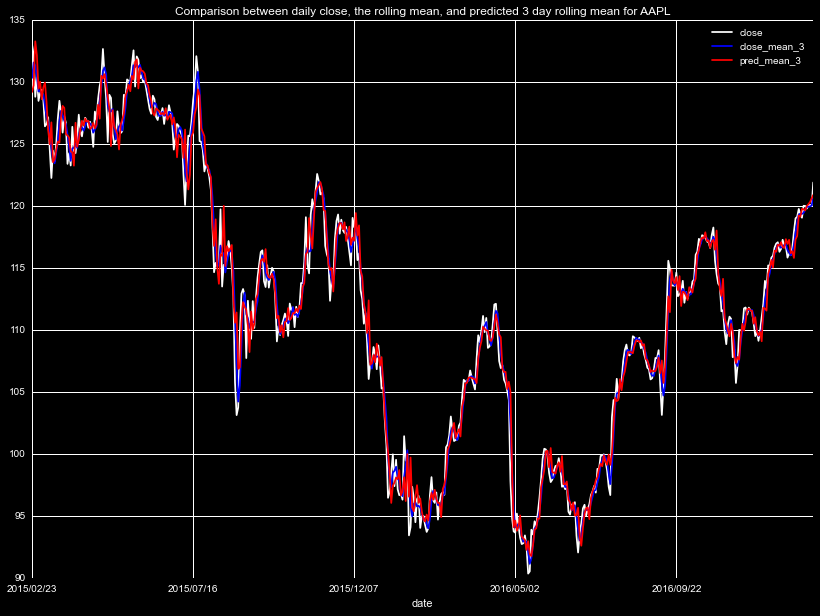

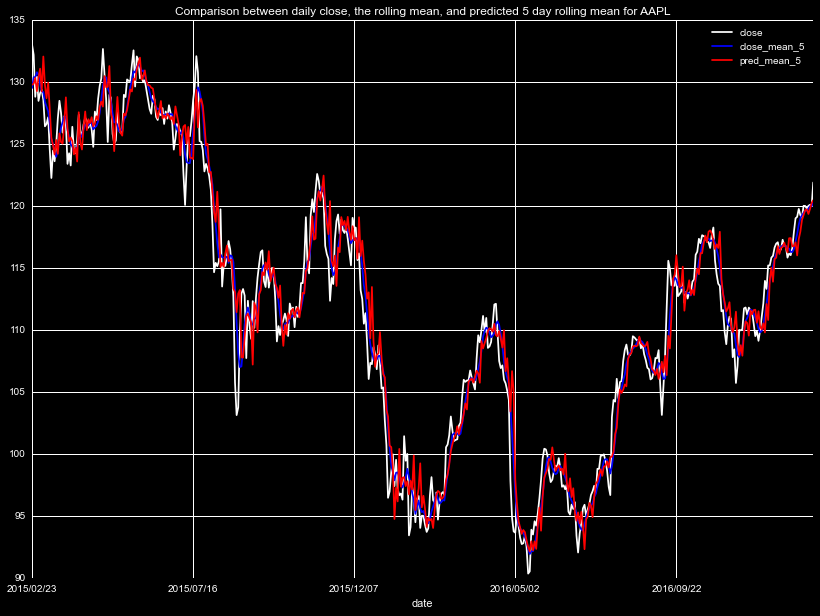

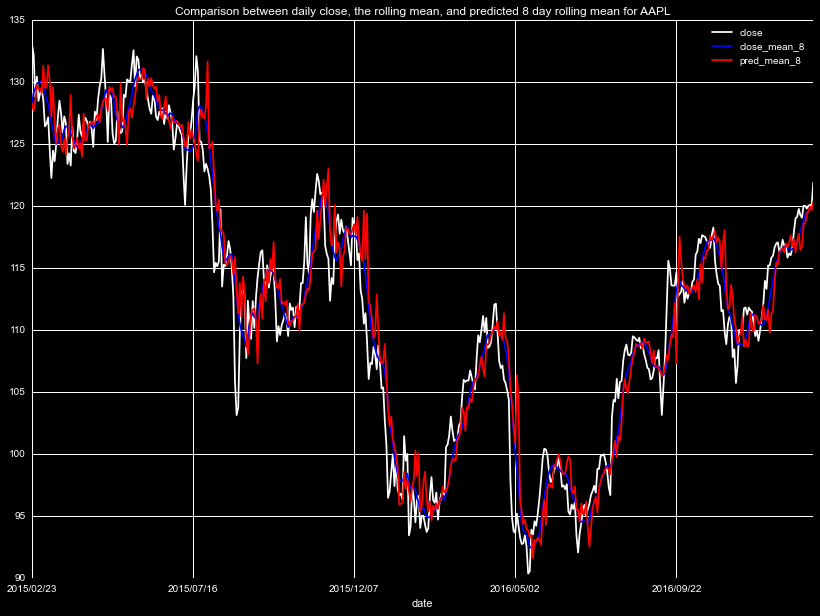

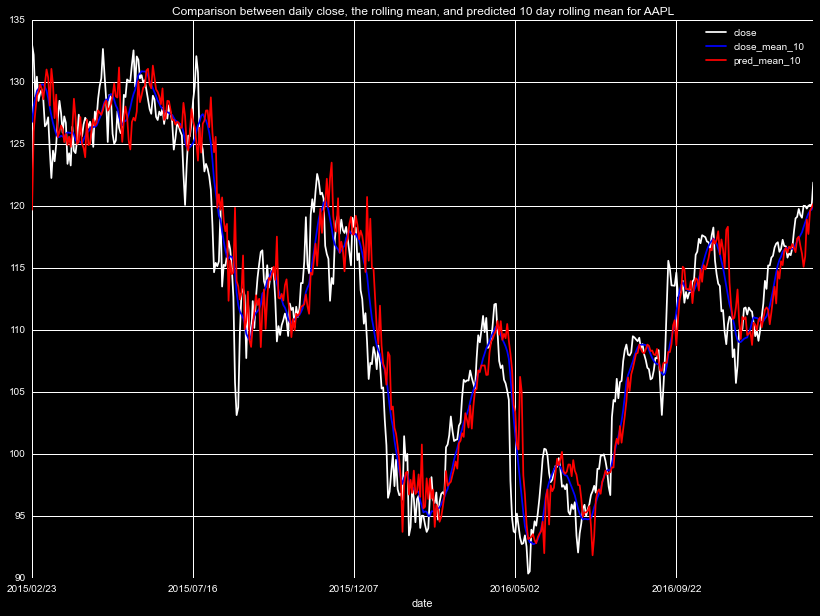

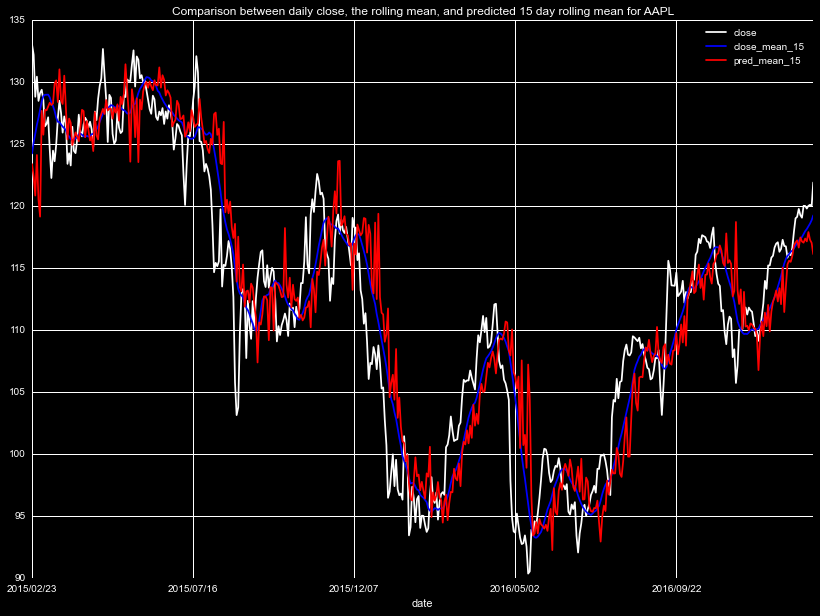

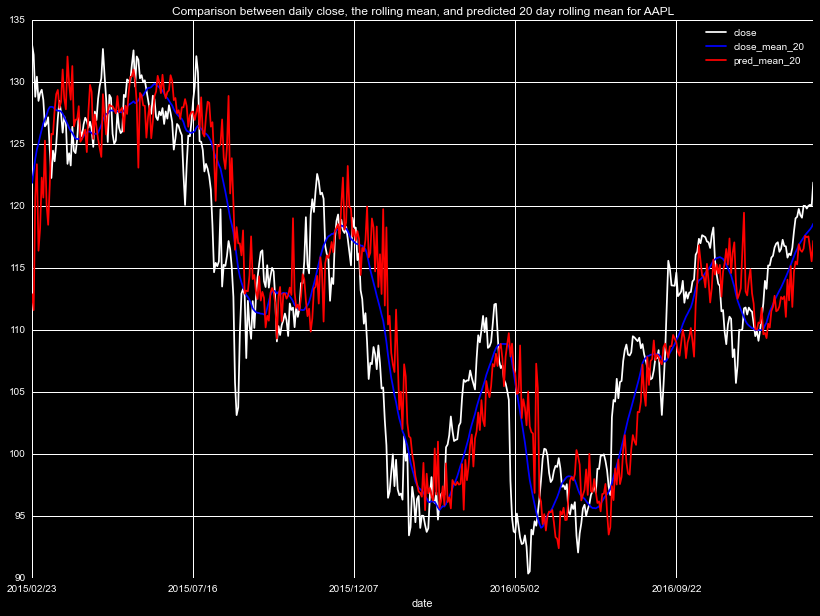

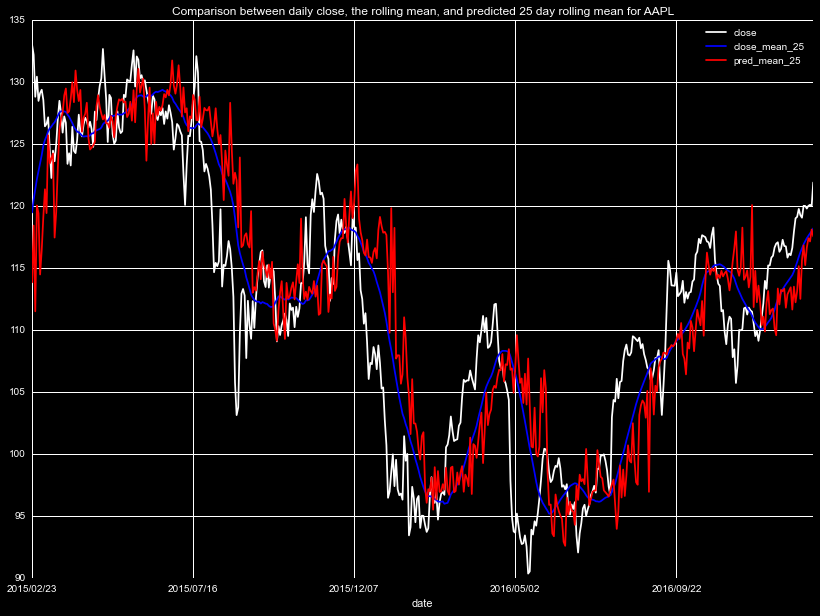

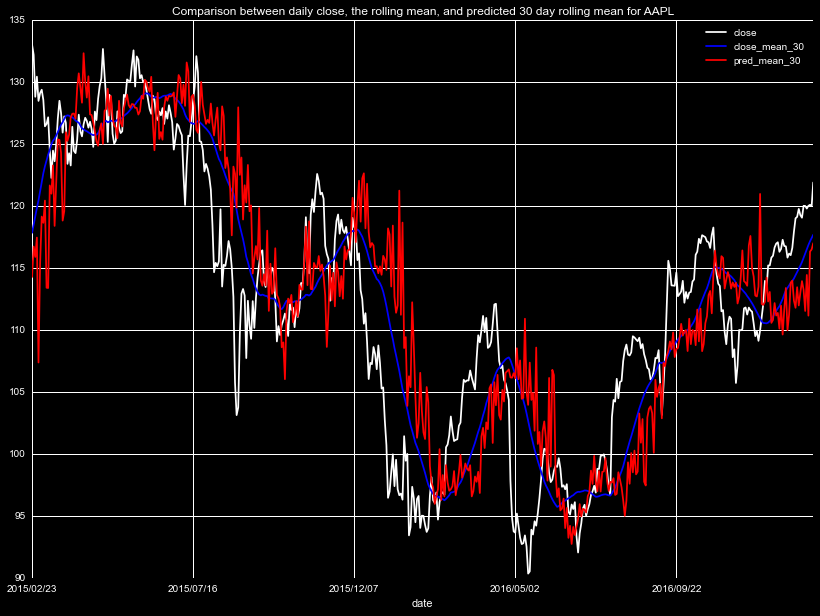

In [111]:
max_ind = close_df.shape[0]
low = int( 0.0*max_ind )
hi  = int( 0.2*max_ind )
for i in roll_nums:
    my_ax = plt.gca()
    close_df[hi:low:-1].plot( y = 'close'             , color='w', ax=my_ax )
    close_df[hi:low:-1].plot( y = 'close_mean_'+str(i), color='b', ax=my_ax )
    close_df[hi:low:-1].plot( y =  'pred_mean_'+str(i), color='r', ax=my_ax )
    plt.title( 'Comparison between daily close, the rolling mean, and predicted ' + str(i) + ' day rolling mean for AAPL' )
#    plt.ylim( 10, 30 )
    plt.show()

In [68]:
# Some values noisy, lets test the trend in rolling means

In [70]:
print close_df['close'].head()
print close_df['close'].shift(-1).head()

date
2017/01/26    121.94
2017/01/25    121.88
2017/01/24    119.97
2017/01/23    120.08
2017/01/20    120.00
Name: close, dtype: float64
date
2017/01/26    121.88
2017/01/25    119.97
2017/01/24    120.08
2017/01/23    120.00
2017/01/20    119.78
Name: close, dtype: float64


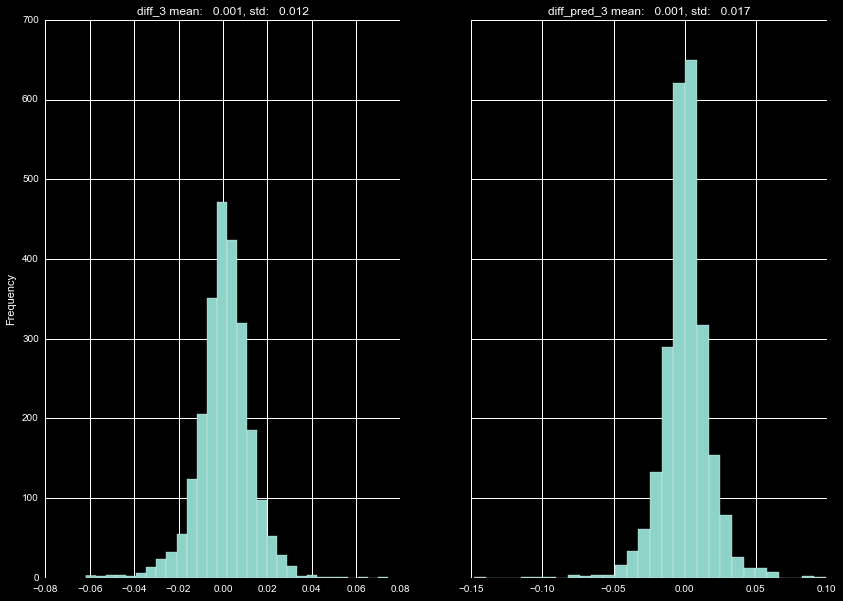

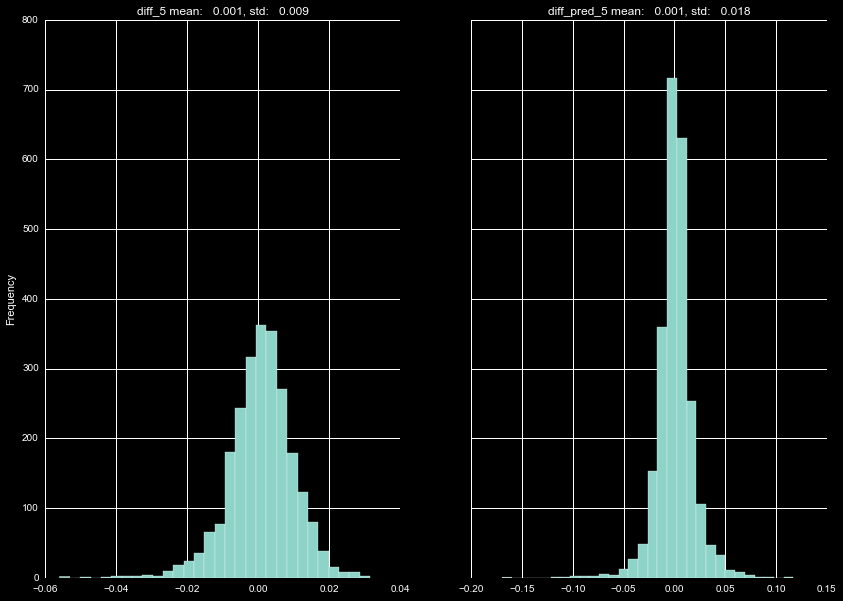

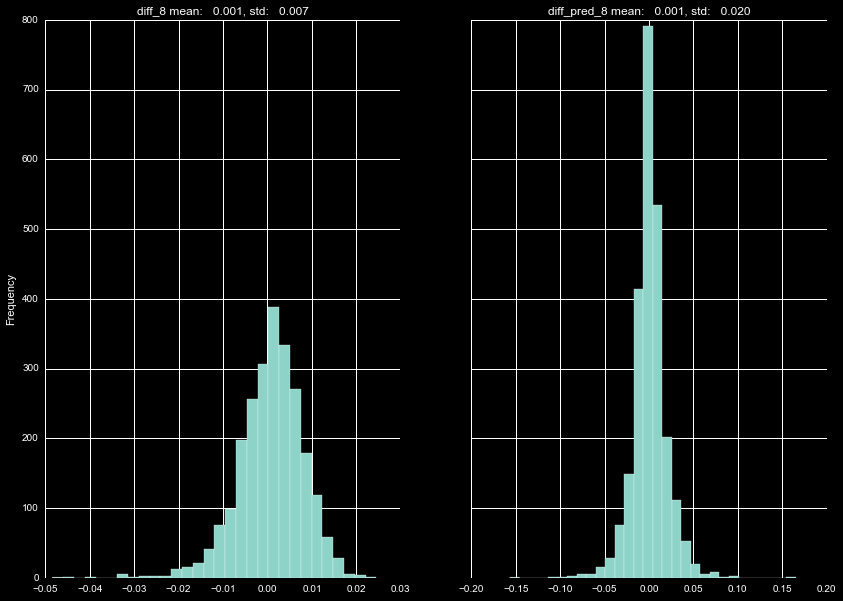

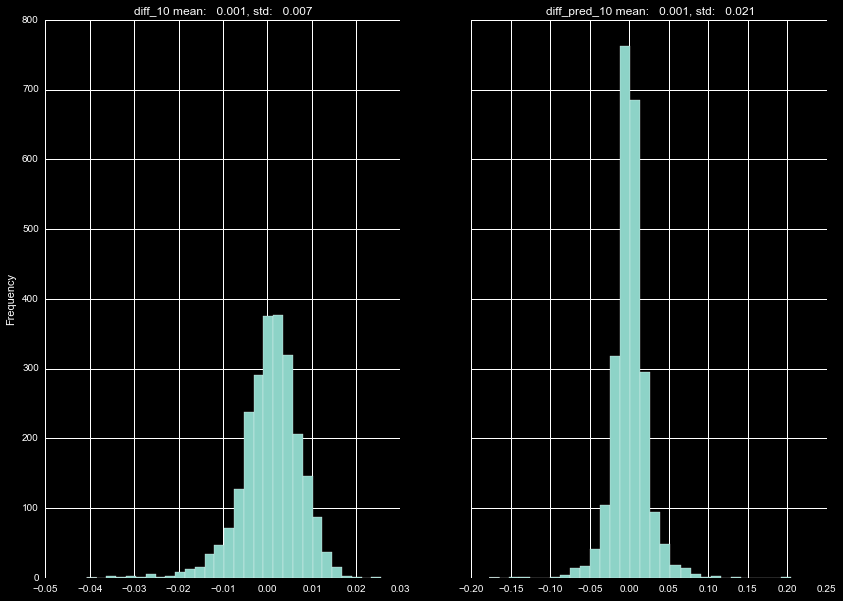

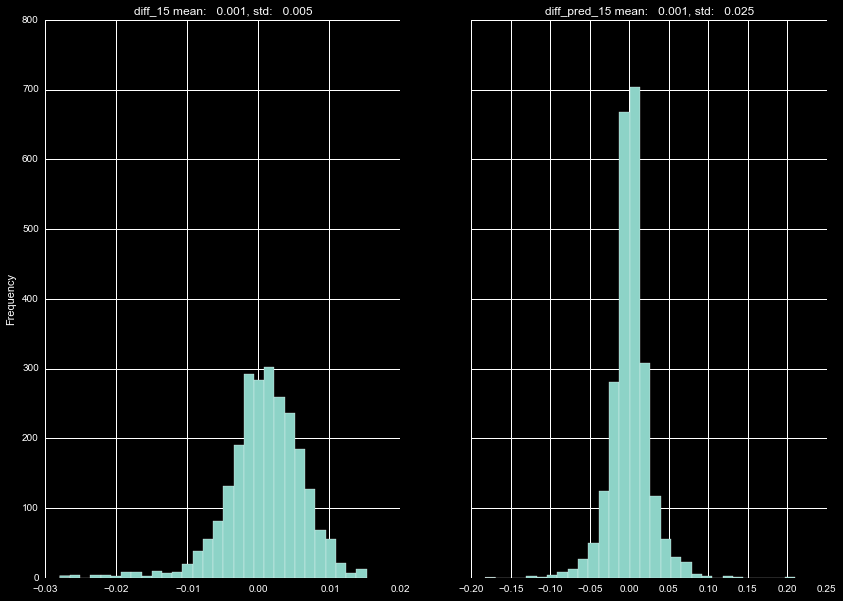

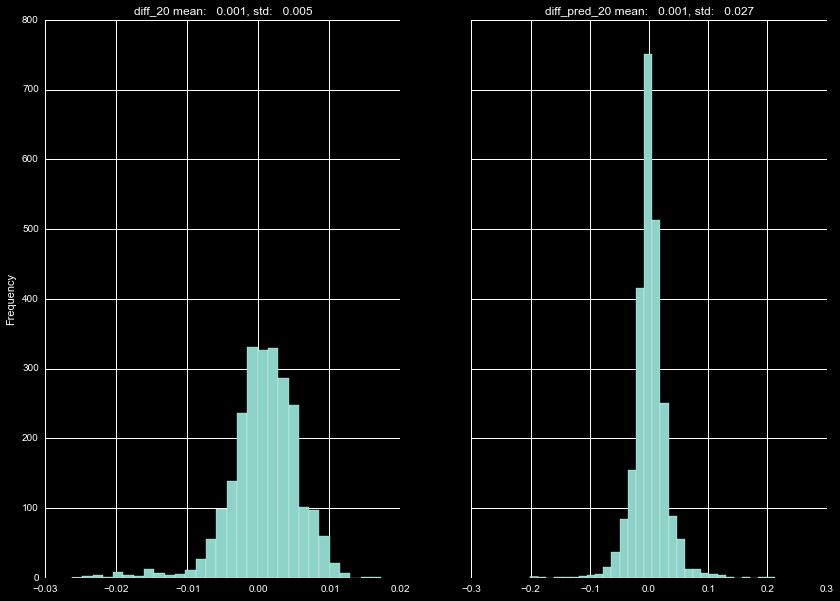

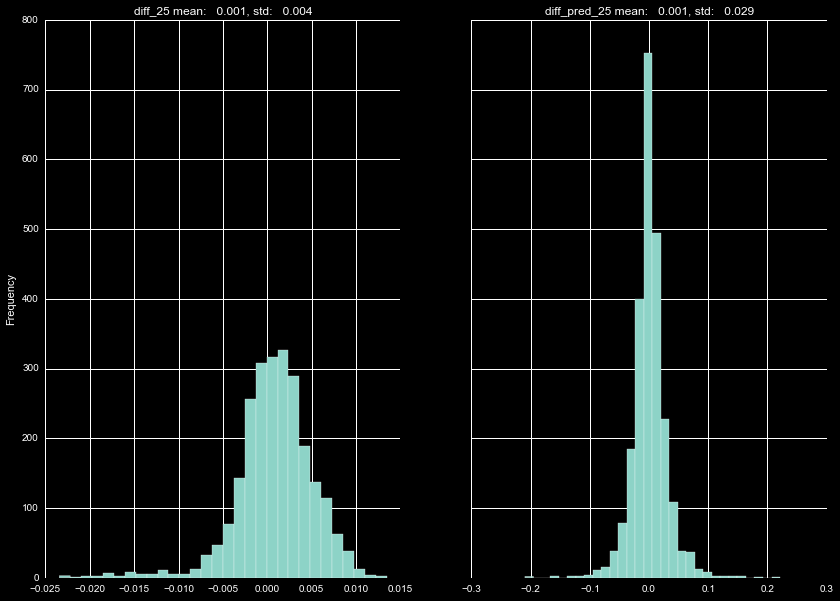

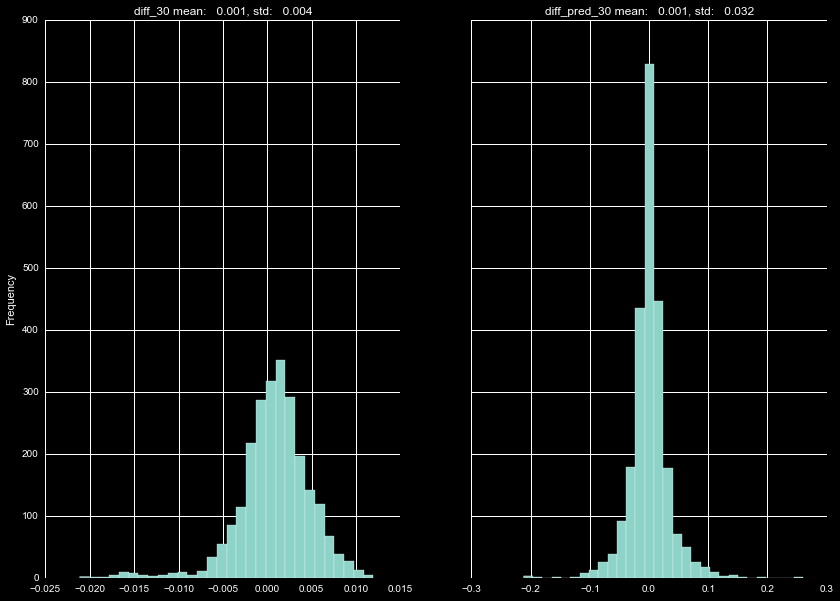

In [77]:
rolling_df = close_df.copy()

for i in roll_nums:
    rolling_df['diff_'     +str(i)] = close_df['close_mean_'+str(i)]/close_df['close_mean_'+str(i)].shift(-1) - 1.
    rolling_df['diff_pred_'+str(i)] = close_df[ 'pred_mean_'+str(i)]/close_df[ 'pred_mean_'+str(i)].shift(-1) - 1.
    
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    rolling_df['diff_'+str(i)].plot.hist( bins=30, ax=ax1 )
    ax1.set_title( 'diff_'+str(i)+ ' mean: %7.3f, std: %7.3f ' % (rolling_df['diff_'+str(i)].mean(),rolling_df['diff_'+str(i)].std()) )
    rolling_df['diff_pred_'+str(i)].plot.hist( bins=30, ax=ax2 )
    ax2.set_title( 'diff_pred_'+str(i)+ ' mean: %7.3f, std: %7.3f ' % (rolling_df['diff_pred_'+str(i)].mean(),rolling_df['diff_pred_'+str(i)].std()) )
    plt.show()

In [186]:
foo = close_df.copy()
for i in roll_nums:
    foo['pred_mean_'+str(i)] = foo['close_mean_'+str(i)].shift(i-1)
foo = foo.dropna( )
bar = close_df[:foo.shape[0]]
foo = fv.pred_from_mean( foo, roll_nums )

In [27]:
print close_df.head(10)

             close  close_mean_3  close_mean_5  close_mean_8  close_mean_10  \
date                                                                          
2017/01/26  121.94    121.263333       120.774     120.45500        120.193   
2017/01/25  121.88    120.643333       120.342     120.09250        119.974   
2017/01/24  119.97    120.016667       119.964     119.76375        119.697   
2017/01/23  120.08    119.953333       119.970     119.73625        119.599   
2017/01/20  120.00    119.923333       119.762     119.61500        119.382   
2017/01/19  119.78    119.923333       119.612     119.48875        119.043   
2017/01/18  119.99    119.676667       119.606     119.25500        118.667   
2017/01/17  120.00    119.430000       119.430     118.83250        118.283   
2017/01/13  119.04    119.346667       119.228     118.33500        117.865   
2017/01/12  119.25    119.370000       119.002     117.97375        117.634   

            close_mean_15  close_mean_20  close_mea

In [29]:
print foo.head(10)

             close  pred_10_day_1  pred_10_day_2  pred_15_day_1  \
date                                                              
2017/01/26  121.94     120.491243     119.688868     119.145834   
2017/01/25  121.88     120.168371     120.124551     112.065089   
2017/01/24  119.97     119.247443     120.459311     113.961899   
2017/01/23  120.08     119.953974     119.239604     115.039486   
2017/01/20  120.00     118.791581     116.654493     118.394602   
2017/01/19  119.78     118.839512     118.944868     115.349083   
2017/01/18  119.99     116.289060     115.542102     118.927063   
2017/01/17  120.00     116.292614     113.873214     119.370538   
2017/01/13  119.04     114.640370     117.641423     117.601284   
2017/01/12  119.25     115.368000     118.179977     117.655899   

            pred_15_day_3  pred_15_day_5  pred_20_day_1  pred_20_day_3  \
date                                                                     
2017/01/26     118.473130     117.800425     11

In [187]:
foo.columns.values

array(['close', 'pred_10_day_1', 'pred_10_day_2', 'pred_15_day_1',
       'pred_15_day_2', 'pred_15_day_3', 'pred_15_day_4', 'pred_15_day_5',
       'pred_20_day_1', 'pred_20_day_2', 'pred_20_day_3', 'pred_20_day_4',
       'pred_20_day_5', 'pred_25_day_1', 'pred_25_day_2', 'pred_25_day_3',
       'pred_25_day_4', 'pred_25_day_5', 'pred_30_day_1', 'pred_30_day_2',
       'pred_30_day_3', 'pred_30_day_4', 'pred_30_day_5', 'pred_3_day_1',
       'pred_3_day_2', 'pred_3_day_3', 'pred_5_day_1', 'pred_5_day_2',
       'pred_8_day_1', 'pred_8_day_2', 'pred_8_day_3'], dtype=object)

In [164]:
foo.shape

(2402, 24)

In [188]:
foo = foo[['close',
           'pred_3_day_1', 'pred_3_day_2', 'pred_3_day_3',
           'pred_5_day_1', 'pred_5_day_2',
           'pred_8_day_1', 'pred_8_day_2', 'pred_8_day_3',
           'pred_10_day_1', 'pred_10_day_2',
           'pred_15_day_1', 'pred_15_day_2', 'pred_15_day_3', 'pred_15_day_4', 'pred_15_day_5',
           'pred_20_day_1', 'pred_20_day_2', 'pred_20_day_3', 'pred_20_day_4', 'pred_20_day_5',
           'pred_25_day_1', 'pred_25_day_2', 'pred_25_day_3', 'pred_25_day_4', 'pred_25_day_5',
           'pred_30_day_1', 'pred_30_day_2', 'pred_30_day_3', 'pred_30_day_4', 'pred_30_day_5'
          ]]

[ 112.52  113.    113.05  113.89  114.06  116.05  116.3   117.34  116.98
  117.63  117.55  117.47  117.12  117.06  116.6   117.65  118.25  115.59
  114.48  113.72  113.54  111.49  111.59  109.83  108.84  110.41  111.06
  110.88  107.79  108.43] [ 112.52        112.85666667  113.19333333  113.08033333  113.52766667
  114.82183333  116.56333333  118.30483333  115.82266667  114.34133333
  116.71422222  116.93711111  117.16        117.38288889  117.60577778
  116.6712      116.3046      115.938       115.5714      115.2048      113.986
  112.522       111.058       109.594       108.13        110.5204
  110.1172      109.714       109.3108      108.9076    ]


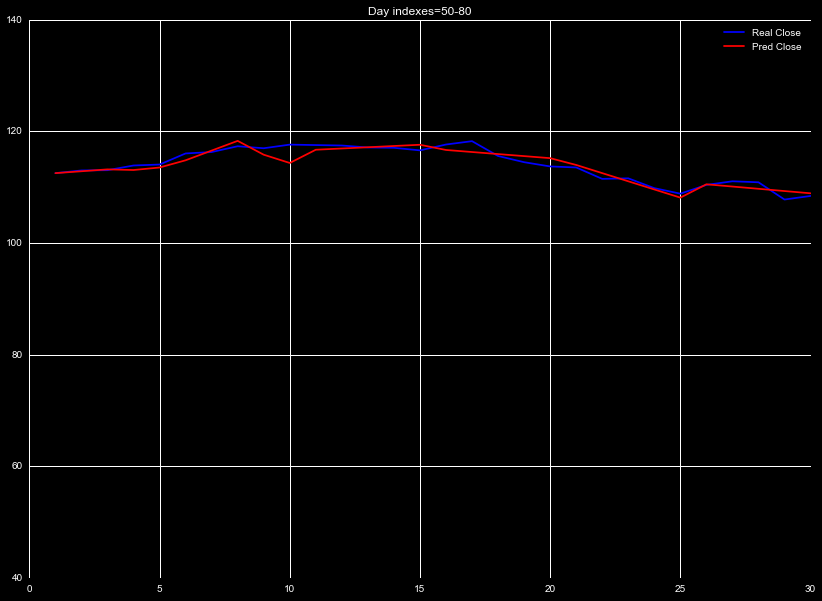

[  98.66   97.34   96.67  102.95  104.34  104.21  106.05  104.48  105.79
  105.87  107.48  108.37  108.81  108.    107.93  108.18  109.48  109.38
  109.22  109.08  109.36  108.51  108.85  108.03  107.57  106.94  106.82
  106.    106.1   106.73] [  98.66         97.55666667   96.45333333   98.77433333  101.20966667
  101.84383333  104.91333333  107.98283333  103.77466667  101.49733333
  106.67022222  107.39411111  108.118       108.84188889  109.56577778
  108.498       108.783       109.068       109.353       109.638       108.8264
  108.6452      108.464       108.2828      108.1016      107.6856
  107.1018      106.518       105.9342      105.3504    ]


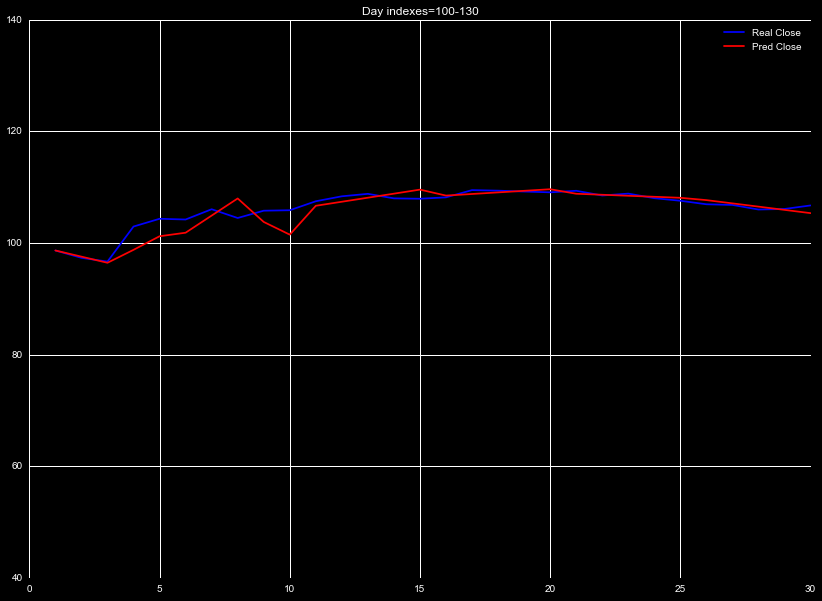

[ 112.65  111.78  112.94  112.54  112.01  113.99  113.91  112.52  110.38
  109.33  106.25  106.26  107.75  111.89  112.01  109.25  110.22  109.8
  106.82  105.99  108.72  109.55  112.4   112.98  113.1   109.14  115.31
  118.9   117.16  118.63] [ 112.65        112.45666667  112.26333333  112.42033333  112.34766667
  112.94683333  113.47333333  113.99983333  112.83916667  111.57083333
  110.16772222  109.49986111  108.832       108.16413889  107.49627778
  108.6656      108.5408      108.416       108.2912      108.1664
  109.5896      110.4698      111.35        112.2302      113.1104
  113.1412      114.4846      115.828       117.1714      118.5148    ]


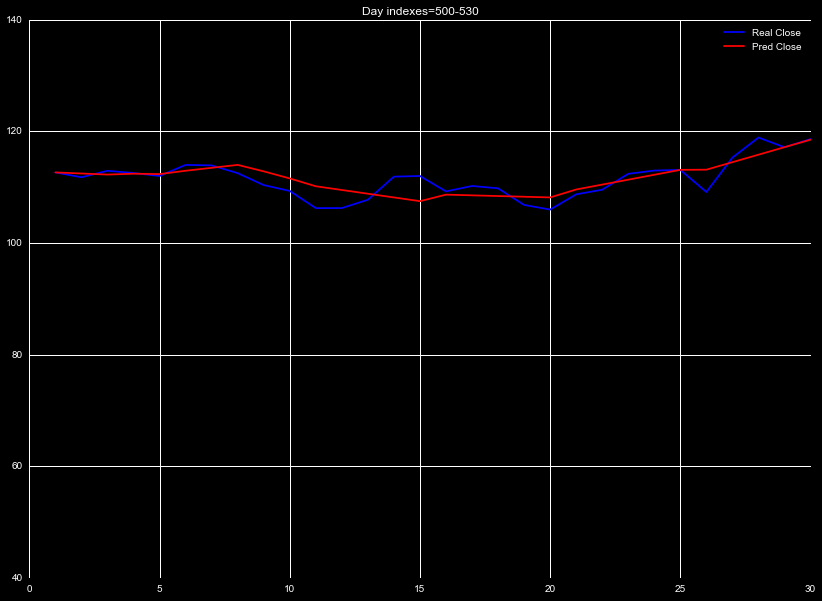

[ 74.3097  73.2856  73.58    72.7984  76.0247  78.4328  77.4422  75.2857
  74.8428  75.0443  73.8714  74.7871  74.3285  71.6785  69.4171  72.2985
  71.8114  71.4285  72.11    73.4293  64.3571  62.84    64.2614  65.4671
  65.2614  65.07    64.8028  63.188   65.4063  65.3357] [ 74.3097      73.7251      73.1405      73.86239     74.13697     75.45797833
  77.05356667  78.649155    76.07909333  74.13014667  73.90404444
  73.36028222  72.81652     72.27275778  71.72899556  72.576128    72.395834
  72.21554     72.035246    71.854952    69.104284    66.770842    64.4374
  62.103958    59.770516    64.566664    64.663612    64.76056     64.857508
  64.954456  ]


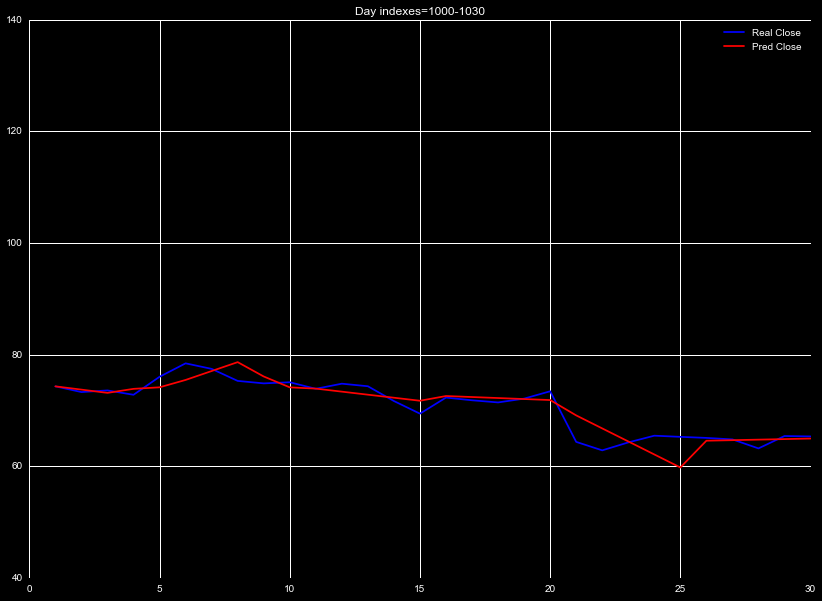

[ 44.45    45.2     45.45    45.3486  45.7357  45.4586  45.8586  45.6796
  45.7943  45.9528  45.7557  45.7657  45.8928  45.8014  46.03    46.315
  46.4514  46.2286  46.3828  46.4957  46.47    46.2371  46.08    47.0814
  47.3271  47.7143  47.6757  48.0171  48.9221  48.8057] [ 44.45        45.03333333  45.61666667  45.13509667  45.33862333
  45.40034833  45.6656      45.93085167  45.57921     45.40643     45.75915
  45.804135    45.84912     45.894105    45.93909     46.059352    46.217026
  46.3747      46.532374    46.690048    46.480468    46.559794    46.63912
  46.718446    46.797772    47.274264    47.750622    48.22698     48.703338
  49.179696  ]


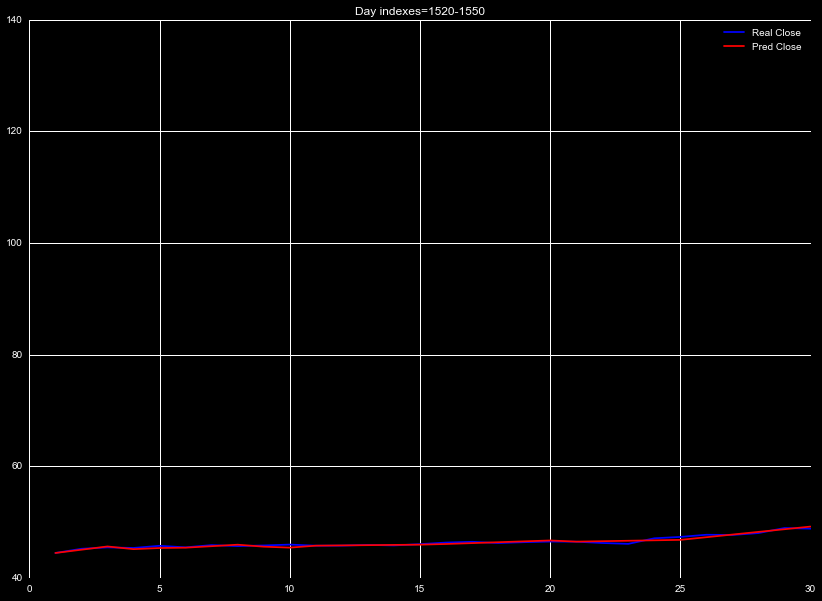

In [190]:
day_list = [ 50, 100, 500, 1000, 1520 ]

day_len = 30

pred_days = range(1,31)#[1,2,3,4,5,6,7,8,9,10,11,13,15,16,18,20,21,23,25,26,28,30]

# Get the real values of the quotes
real_values = []
for i in day_list:
    real_values.append( foo['close'].values[ i:i-day_len:-1 ] )
    
    
# Get predicted values 
pred_values = []
for i in day_list:
    pred_values.append( foo.drop( 'close', axis=1 ).values[ i, 0:len(pred_days) ] )
    
    

# Plot the results
for i in range( 0, len( day_list) ):
    print real_values[i], pred_values[i]
    plt.plot( range( 1, day_len+1 ), real_values[i], color='b', label='Real Close' )
    plt.plot(           pred_days  , pred_values[i], color='r', label='Pred Close' )
    plt.ylim( [40, 140] )
    plt.title( 'Day indexes=%i-%i'%(day_list[i], day_list[i]+30) )
    plt.legend()
    plt.show()